## Fine-tuning for Classification

After defining the architecture of our model and pre-training it on raw text, we can start fine-tuning it on a particular application. In this notebook we will train it on a binary classification task for spam detection.

Generally, there are two common way so fine-tuning a model:

- classification finetuning
- instruction finetuning

Instruction fine-tuning involves training the model on a natural language prompts to improve its ability to understand and execute tasks. Such a model usually needs to handle a wider variety of tasks than a classification finetuned model which is tasked to perform well on one particular application.

This also means that instruction fine-tuning requires more data for training to make it understand more open, natural language, prompts. For this reason we will focus on classification fine-tuning in this Chapter and start by defining the dataset below.

### Preparing the dataset

First, we have to download our spam / not spam dataset as defined below.

In [1]:
import os
import urllib.request
import zipfile
from pathlib import Path

# Download the dataset
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
filename = "sms-spam-collection.zip"
extracted_path = "sms-spam-collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(
    url: str,
    zip_path: Path,
    extracted_path: Path,
    data_file_path: Path,
):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return
    
    with urllib.request.urlopen(url) as response:
        with open(zip_path, 'wb') as f:
            f.write(response.read())
    
    # Unzip the dataset
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)
    
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"Dataset downloaded and extracted to {data_file_path}")

# Download and unzip the dataset
download_and_unzip_spam_data(url, Path(filename), Path(extracted_path), Path(data_file_path))

sms-spam-collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


We can now look at some samples of our dataset.

In [2]:
import pandas as pd

df = pd.read_csv(data_file_path, sep='\t', header=None, names=['label', 'message'])
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
# Look at class distribution
print(df['label'].value_counts())

label
ham     4825
spam     747
Name: count, dtype: int64


In order to have a balanced dataset - and a small one we can quickly train locally - we just undersample and consider 747 samples of each class.

In [4]:
def create_balanced_dataset(df: pd.DataFrame, num_samples: int) -> pd.DataFrame:
    # Count the number of spam and ham messages
    spam_count = df[df['label'] == 'spam'].shape[0]
    ham_count = df[df['label'] == 'ham'].shape[0]
    
    # Calculate the number of samples to keep for each class
    num_samples_per_class = min(num_samples, spam_count, ham_count)

    # Randomly sample the number of samples for each class
    spam_samples = df[df['label'] == 'spam']
    ham_samples = df[df['label'] == 'ham'].sample(num_samples_per_class, random_state=123)

    # Concatenate the samples and shuffle
    balanced_df = pd.concat([ham_samples, spam_samples]).reset_index(drop=True)

    return balanced_df

balanced_df = create_balanced_dataset(df, 747)
print(balanced_df['label'].value_counts())

label
ham     747
spam    747
Name: count, dtype: int64


Next, we create a column for our binary classification from the text column `label`.

In [5]:
balanced_df['label'] = balanced_df.label.map({"ham": 0, "spam": 1})

Now we split the dataset into train/validation/test splits where we use 70%, 10% and 20% of the data respectively.

In [6]:
def random_split(df: pd.DataFrame, train_frac: float, val_frac: float) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    train_end = int(train_frac * len(df))
    val_end = train_end + int(val_frac * len(df))

    train_df = df[:train_end]
    val_df = df[train_end:val_end]
    test_df = df[val_end:]

    return train_df, val_df, test_df

train_df, val_df, test_df = random_split(balanced_df, 0.7, 0.1)

# Save to csv
train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)
test_df.to_csv("test.csv", index=False)

#### Creating data loaders

We will now define data loaders similar to previous chapters.

Previously, we used a sliding window approach to create samples of uniform length which we then grouped into batches. We do not want to simply cut off our messages in the current scenario and have two options:

- truncate all messages to the length of the shortest messages in the dataset or batch
- pad all messages to the length of the longest message in the dataset or batch

With the first option we would throw away a significant amount of information even though it is computationally cheaper. For this reason we pick option 2.

To create batches of samples with the same length, we use `<|endoftext|>` as a padding token. We will do this after converting the text to the token IDs. Our padding string has token ID 50256 which we can double check from the tiktoken tokenizer.

In [7]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


The first part we need to implement now is the `Dataset` class. It will contain the loading and pre-precessing of our dataset before we can create the input batches in our data loaders.

In [8]:
import torch
from torch.utils.data import Dataset


class SpamDataset(Dataset):
    def __init__(
            self,
            csv_file: str,
            tokenizer: tiktoken.Encoding,
            max_length: int = None,
            pad_token_id: int = 50256
        ):
        self.data = pd.read_csv(csv_file)

        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["message"]
        ]

        if max_length is not None:
            self.max_length = max_length
            self.encoded_texts = [
                encoded_text[:max_length]
                for encoded_text in self.encoded_texts
            ]
        else:
            self.max_length = self._longest_encoded_length()

        # Pad the encoded texts to the max length
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        encoded = self.encoded_texts[idx]
        label = self.data.iloc[idx]["label"]

        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )
    
    def __len__(self) -> int:
        return len(self.encoded_texts)

    def _longest_encoded_length(self) -> int:
        max_length = 0
        for encoded_text in self.encoded_texts:
            if len(encoded_text) > max_length:
                max_length = len(encoded_text)
        return max_length 

In [9]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    tokenizer=tokenizer,
    max_length=None
)

print("max length of encoded texts:", train_dataset.max_length)

val_dataset = SpamDataset(
    csv_file="val.csv",
    tokenizer=tokenizer,
    max_length=train_dataset.max_length
)

test_dataset = SpamDataset(
    csv_file="test.csv",
    tokenizer=tokenizer,
    max_length=train_dataset.max_length
)

max length of encoded texts: 120


Next, we implement the data loader.

In [10]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)

print(f"Number of batches in train loader: {len(train_loader)}")
print(f"Number of batches in val loader: {len(val_loader)}")
print(f"Number of batches in test loader: {len(test_loader)}")

for input_batch, target_batch in train_loader:
    print("Input batch dimensions:", input_batch.shape)
    print("Target batch dimensions:", target_batch.shape)
    break

Number of batches in train loader: 130
Number of batches in val loader: 19
Number of batches in test loader: 38
Input batch dimensions: torch.Size([8, 120])
Target batch dimensions: torch.Size([8])


### Initializing the model with pretrained weights

We will use the GPT-2 small model to finetune on our dataset and start by defining the same configurations as in previous chapters.

In [11]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"
BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True,
}
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

We can now load our pretrained model.

In [12]:
import os
import sys

sys.path.append(os.path.dirname(os.path.abspath(".")))

from Chapter4.gpt_model import GPTModel
from Chapter5.gpt_download import download_and_load_gpt2
from Chapter5.load_weights_for_gpt import load_weights_into_gpt

model_size = CHOOSE_MODEL.split(" ")[1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (ln1): LayerNorm()
      (ln2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_qu

We can now use our text utilities from earlier chapters to test that the model generates coherent text.

In [13]:
from Chapter4.generate_text_simple import generate_text_simple
from Chapter5.tokenize_utils import text_to_token_ids, token_ids_to_text

text1 = "Every effort moves you"
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


Let's check if the model can already classify spam, without fine-tuning it.

In [14]:
text2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    "'You are a winner you have been specifically"
    " selected to receive $1000 cash or a $2000 award.'"
)
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no':'You are a winner you have been specifically selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no':'You are a winner


From this output it is clear that the model currently cannot classify spam. We will now fine-tune it on our dataset to improve its performance.

### Adding a classification head

In order to prepare the model for classification we need to modify it's architecture. We will replace the original output layer, which maps hidden units to a representation of our vocabulary with a smaller output layer that maps the hidden units to 2 classes:

- 0 for not spam
- 1 for spam

NOTE: Given we deal with a binary classification, we could also just use a single output node. This would require us to update the loss function.

We will print the model architecture below so we can verify the current output layer configuration.

In [15]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (ln1): LayerNorm()
      (ln2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_qu

Given we only want to finetune the last layer few layers, we start by freezing all layers to make them non-trainable. Then we replace the current output layer with the new one and unfreeze the layers we actually want to train. 

While we could only train the updated output layer, the fine-tuned model will usually perform better if we also allow for updates to a few additional layers. We thus also make the last transformer block and layer norm trainable.

In [16]:
for param in model.parameters():
    param.requires_grad = False

torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"],
    out_features=num_classes,
)

for param in model.transformer_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

We can feed this updated model the same text as before:

In [17]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs, dtype=torch.long).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs shape:", inputs.shape)

with torch.no_grad():
    outputs = model(inputs)

print("Outputs:", outputs)
print("Outputs shape:", outputs.shape)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs shape: torch.Size([1, 4])
Outputs: tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs shape: torch.Size([1, 4, 2])


We can see the updated output shape with an embedding dimension of only 2 instead of the previous 50257.

The second dimension - 4 - corresponds to the number of input tokens which are 4 in the example. Given we only want to classify "spam" or "not spam", we do not need to finetune all 4 rows but can focus on the last one instead. We can print only the last row as follows:

In [18]:
print("Last output token:", outputs[0, -1, :])

Last output token: tensor([-3.5983,  3.9902])


We pick the last token in particular because of how the attention mechanism works. Given the causal mask in our self attention unit allows the model to focus on the current token and any tokens before that, it is the last token which contains the most information as it sees the full sample.

### Calculating classification loss and accuracy

In order to evaluate the model, we still need to compute the loss and accuracy for it. To do this, we also need to convert the predictions from the last token into class label predictions.

Previously we picked the most probably next token by applying a softmax function to the output and using the argmax to find the hightest probability token. We can do the same here in our spam classification. Given the softmax function is monotonous, we will simply take the argmax of the logits.

In [19]:
logits = outputs[0, -1, :]
label = torch.argmax(logits)
print("Predicted label:", label)

Predicted label: tensor(1)


We next define our helper functions to compute the accuracy.

In [20]:
def calc_accuracy_loader(
        data_loader: DataLoader, 
        model: torch.nn.Module, 
        device: torch.device, 
        num_batches: int | None = None
) -> float:
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            with torch.no_grad():
                outputs = model(input_batch)
                logits = outputs[:, -1, :]
                
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break

    return correct_predictions / num_examples

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(
    data_loader=train_loader,
    model=model,
    device=device,
    num_batches=10
)
val_accuracy = calc_accuracy_loader(
    data_loader=val_loader,
    model=model,
    device=device,
    num_batches=10
)
test_accuracy = calc_accuracy_loader(
    data_loader=test_loader,
    model=model,
    device=device,
    num_batches=10
)

print(f"Train accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Train accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


Given the accuracy is around 50% on this untrained model we essentially have random predictions at this point.

Before we can fine-tune the model to improve the accuracy, we still need to define our loss.

In [22]:
def calc_loss_batch(
        input_batch: torch.Tensor, 
        target_batch: torch.Tensor, 
        model: torch.nn.Module, 
        device: torch.device
) -> torch.Tensor:
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)[:, -1, :]
    loss = torch.nn.functional.cross_entropy(logits, target_batch)

    return loss

def calc_loss_loader(
        data_loader: DataLoader,
        model: torch.nn.Module,
        device: torch.device,
        num_batches: int | None = None
) -> float:
    total_loss = 0
    if len(data_loader) == 0:
        return float('nan')
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch=input_batch,
                target_batch=target_batch,
                model=model,
                device=device
            )
            total_loss += loss.item()
        else:
            break

    return total_loss / num_batches

In [23]:
with torch.no_grad():
    train_loss = calc_loss_loader(
        data_loader=train_loader,
        model=model,
        device=device,
        num_batches=5
    )
    val_loss = calc_loss_loader(
        data_loader=val_loader,
        model=model,
        device=device,
        num_batches=5
    )
    test_loss = calc_loss_loader(
        data_loader=test_loader,
        model=model,
        device=device,
        num_batches=5
    )

print(f"Train loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Train loss: 2.453
Validation loss: 2.583
Test loss: 2.322


### Fine-tuning the model on supervised data

Now we define the trainig function we will use for our supervised finetuning. The function will be very similar to the one we defined in a previous chapter. The only differences are that we will track the number of samples seen and compute and print the accuracy after every epoch instead of printing a sample text completion.

In [24]:
def train_classifier_simple(
        model: torch.nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        optimizer: torch.optim.Optimizer,
        device: torch.device,
        num_epochs: int,
        eval_freq: int,
        eval_iter: int
) -> tuple[list[float], list[float], list[float], list[float], int]:
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(
                input_batch=input_batch,
                target_batch=target_batch,
                model=model,
                device=device
            )
            loss.backward()
            optimizer.step()

            examples_seen += input_batch.shape[0]
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model=model,
                    train_loader=train_loader,
                    val_loader=val_loader,
                    device=device,
                    eval_iter=eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss: {train_loss:.4f}, "
                      f"Val loss: {val_loss:.4f}")

        train_acc = calc_accuracy_loader(
            data_loader=train_loader,
            model=model,
            device=device,
            num_batches=eval_iter
        )
        val_acc = calc_accuracy_loader(
            data_loader=val_loader,
            model=model,
            device=device,
            num_batches=eval_iter
        )

        print(f"Training accuracy: {train_acc*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_acc*100:.2f}%")

        train_accs.append(train_acc)
        val_accs.append(val_acc)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

def evaluate_model(
        model: torch.nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        device: torch.device,
        eval_iter: int
) -> tuple[float, float]:
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            data_loader=train_loader,
            model=model,
            device=device,
            num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            data_loader=val_loader,
            model=model,
            device=device,
            num_batches=eval_iter
        )
    model.train()

    return train_loss, val_loss

Now we can 

- initialize the optimizer
- set the number of training epochs
- start the training

In [25]:
import time

start_time = time.time()
torch.manual_seed(123)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=5e-5,
    weight_decay=0.1
)
num_epochs = 5

train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=50,
    eval_iter=5
)

end_time = time.time()
execution_time_mins = (end_time - start_time) / 60
print(f"Total training time: {execution_time_mins:.2f} minutes")

Ep 1 (Step 000000): Train loss: 2.1534, Val loss: 2.3919
Ep 1 (Step 000050): Train loss: 0.6170, Val loss: 0.6371
Ep 1 (Step 000100): Train loss: 0.5231, Val loss: 0.5574
Training accuracy: 70.00% | Validation accuracy: 72.50%
Ep 2 (Step 000150): Train loss: 0.5605, Val loss: 0.4886
Ep 2 (Step 000200): Train loss: 0.4190, Val loss: 0.3966
Ep 2 (Step 000250): Train loss: 0.4089, Val loss: 0.3531
Training accuracy: 82.50% | Validation accuracy: 85.00%
Ep 3 (Step 000300): Train loss: 0.3334, Val loss: 0.3204
Ep 3 (Step 000350): Train loss: 0.3400, Val loss: 0.3062
Training accuracy: 90.00% | Validation accuracy: 90.00%
Ep 4 (Step 000400): Train loss: 0.1363, Val loss: 0.2001
Ep 4 (Step 000450): Train loss: 0.1531, Val loss: 0.1322
Ep 4 (Step 000500): Train loss: 0.2224, Val loss: 0.1366
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss: 0.2066, Val loss: 0.1434
Ep 5 (Step 000600): Train loss: 0.0832, Val loss: 0.0736
Training accuracy: 100.00% | Valid

Let's plot the loss curve for training and validation.

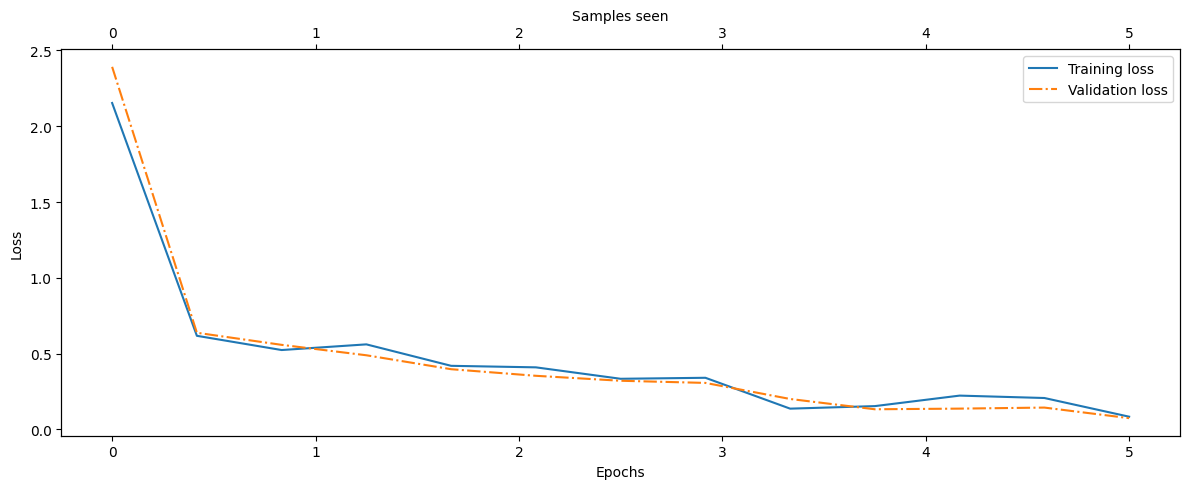

In [26]:
import matplotlib.pyplot as plt


def plot_values(
    epochs_seen: list[int],
    examples_seen: list[int],
    train_values: list[float],
    val_values: list[float],
    label: str,
):
    fig, ax1 = plt.subplots(figsize=(12, 5))

    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    ax2 = ax1.twiny()
    # Invisible plot to set the ticks
    ax2.plot(examples_seen, train_values, alpha=0)
    ax2.set_xlabel("Samples seen")

    fig.tight_layout()
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(
    epochs_seen=epochs_tensor.tolist(),
    examples_seen=examples_seen_tensor.tolist(),
    train_values=train_losses,
    val_values=val_losses,
    label="loss"
)

From the sharp downward trend at the beginning we can see that the model learnt well. Given the validation curve is overlapping the training curve there is no indication of overfitting.

Let's now also plot the classification accuracies.

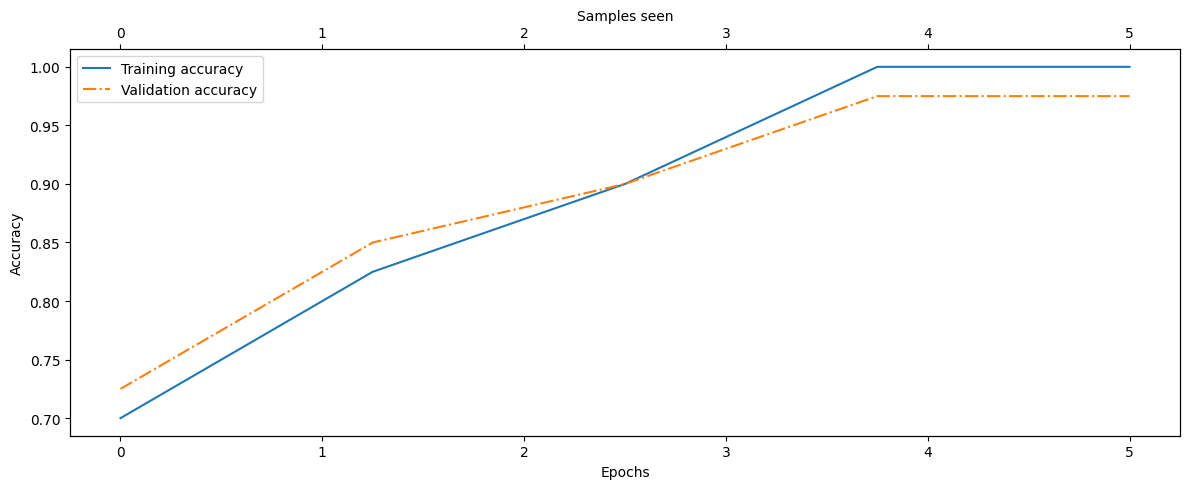

In [27]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(
    epochs_seen=epochs_tensor.tolist(),
    examples_seen=examples_seen_tensor.tolist(),
    train_values=train_accs,
    val_values=val_accs,
    label="accuracy"
)

We achieve a relatively high accuracy of around 97%. Given we evaluate only on 5 batches (`eval_iter` is set to 5), this is only a rough estimate. Let's calculate train, validation and test accuracies across the full dataset.

In [28]:
train_accuracy = calc_accuracy_loader(
    data_loader=train_loader,
    model=model,
    device=device,
)
val_accuracy = calc_accuracy_loader(
    data_loader=val_loader,
    model=model,
    device=device,
)
test_accuracy = calc_accuracy_loader(
    data_loader=test_loader,
    model=model,
    device=device,
)

print(f"Train accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Train accuracy: 97.21%
Validation accuracy: 97.32%
Test accuracy: 95.67%


### Using the LLM as a spam classifier

After fine-tuning our model we can now use it for spam classification. In order to do that, we first create a preprocessing function. Then we can use the model to predict the class label for our samples and return the class name.

In [29]:
def classify_review(
        text: str,
        model: torch.nn.Module,
        tokenizer: tiktoken.Encoding,
        device: torch.device,
        max_length: int = None,
        pad_token_id: int = 50256
) -> str:
    model.eval()

    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[1]
    
    input_ids = input_ids[:min(
        max_length, supported_context_length
    )]

    input_ids += [pad_token_id] * (max_length - len(input_ids))

    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)

    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]

    predicted_label = torch.argmax(logits, dim=-1).item()

    return "spam" if predicted_label == 1 else "not spam"

In [30]:
text_1 = (
    "You are a winner you have been specifically"
    "selected to receive $1000 cash or a $2000 award."
)
print(classify_review(
    text=text_1,
    model=model,
    tokenizer=tokenizer,
    device=device,
    max_length=train_dataset.max_length
))

text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)
print(classify_review(
    text=text_2,
    model=model,
    tokenizer=tokenizer,
    device=device,
    max_length=train_dataset.max_length
))

spam
not spam


We can now save the fine-tuned model weights.

In [31]:
torch.save(model.state_dict(), "review_classifier.pth")

Loading those weights can be done as follows:

In [32]:
model_state_dict = torch.load("review_classifier.pth", map_location=device)
model.load_state_dict(model_state_dict)

<All keys matched successfully>